In [ ]:
def preprocess_data(file_path):

    import pandas as pd
    import numpy as np
    from scipy import stats
    from sklearn.preprocessing import StandardScaler

    data = pd.read_csv(file_path)
    
    data_cleaned = data.drop_duplicates()

    data_cleaned = data_cleaned.dropna()

    numeric_cols = data_cleaned.select_dtypes(include=[np.number]).columns
    z_scores = np.abs(stats.zscore(data_cleaned[numeric_cols]))
    outliers_removed = data_cleaned[(z_scores < 3).all(axis=1)].copy()
    
    return outliers_removed

data = preprocess_data("Perovskite.csv")

print("Final DataFrame Info:")
print(data.info())

Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 247 entries, 0 to 259
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   compound          247 non-null    object 
 1   concentration_mM  247 non-null    int64  
 2   annealing_T       247 non-null    int64  
 3   molecular_weight  247 non-null    float64
 4   C                 247 non-null    int64  
 5   H                 247 non-null    int64  
 6   Br                247 non-null    int64  
 7   I                 247 non-null    int64  
 8   N                 247 non-null    int64  
 9   Hbond_donor       247 non-null    int64  
 10  rotatable_bond    247 non-null    int64  
 11  topPolar_area     247 non-null    float64
 12  heavy_atom        247 non-null    int64  
 13  complexity        247 non-null    float64
 14  xlogP             247 non-null    float64
 15  param1_r          247 non-null    float64
 16  param2_r          247 

In [ ]:
import pandas as pd
from sklearn.model_selection import LeaveOneOut
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np

data = preprocess_data("Perovskite.csv")

features = ['concentration_mM', 'annealing_T', 'molecular_weight', 'C', 'H', 'Br', 'I', 'N', 'Hbond_donor', 'rotatable_bond', 'topPolar_area', 'heavy_atom', 'complexity', 'xlogP']
target = 'xinterp_r'

X = data[features]
y = data[target]

tree_reg = DecisionTreeRegressor(ccp_alpha=30)

loo = LeaveOneOut()
rmse_list = []

for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    tree_reg.fit(X_train, y_train)
    
    y_pred = tree_reg.predict(X_test)
    
    rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
    rmse_list.append(rmse)

mean_rmse = np.mean(rmse_list)
std_rmse = np.std(rmse_list)

print(f"Mean RMSE: {mean_rmse}  St. Deviation RMSE: {std_rmse}")


Mean RMSE: 46.5300956391632  St. Deviation RMSE: 51.98658708652633


'\nQ: What is the function of hyperparameter ccp_alpha ?\n\nA: The hyperparameter ccp_alpha controls the cost-complexity \npruning process, which helps avoid overfitting by penalizing tree complexity. \nIt prunes nodes from the tree by removing branches that offer minimal improvement\nin impurity, balancing the trade-off between tree complexity and prediction accuracy. \nA higher ccp_alpha results in more aggressive pruning, leading to a simpler tree.\n'

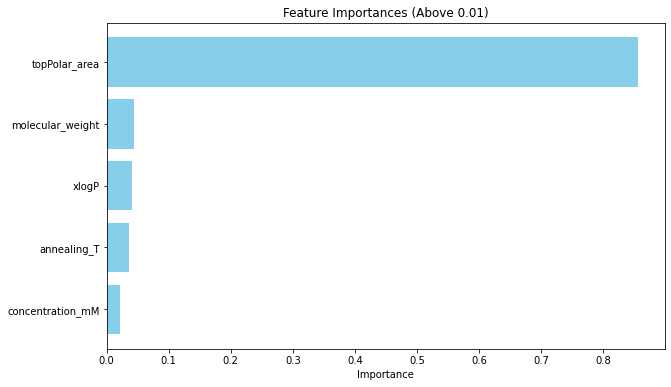

'\nQ: Explain how at least one of these features could be correlated with degradation.\n\nA: \n\n'

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

important_features = tree_reg.feature_importances_

imp_features_df = pd.DataFrame({
    "Feature": features,
    "Importance": important_features
})

imp_features = imp_features_df[imp_features_df["Importance"] > 0.01]

imp_features = imp_features.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(imp_features['Feature'], imp_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances (Above 0.01)')
plt.gca().invert_yaxis()
plt.show()

top_3_features = imp_features.head(3)
top_3_features


Fitting 247 folds for each of 27 candidates, totalling 6669 fits


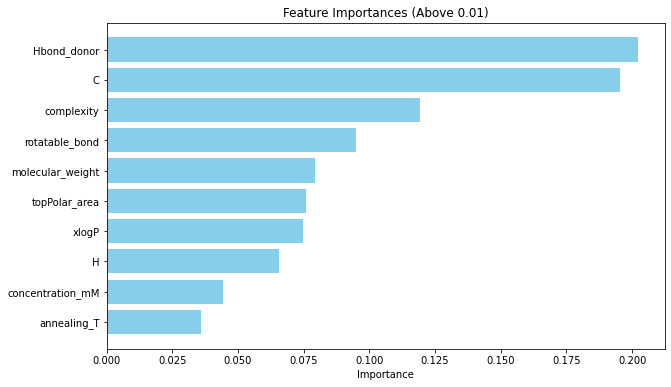

"\nOutputs [optimal hyperparameters and RSME]:  ({'max_features': 1, 'max_leaf_nodes': 10, 'n_estimators': 10}, 52.45)\n\nQ: Prove that your hyperparameter optimized Random Forest model is superior to the\nsingle decision tree you used previously.\n\nA: The RMSE score of this model is 0.5245, compared to 0.4653 of the single decision tree.\nIt also has more features that have relevant importance scores, meaning that the model doesn't\nessentailly depend on only 1 feature, as the single decision tree does.\n\n"

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

data = preprocess_data("Perovskite.csv")

features = ['concentration_mM', 'annealing_T', 'molecular_weight', 'C', 'H', 'Br', 'I', 'N', 'Hbond_donor', 'rotatable_bond', 'topPolar_area', 'heavy_atom', 'complexity', 'xlogP']
target = 'xinterp_r'

X = data[features]
y = data[target]

param_grid = {
    'n_estimators': [10, 20, 100],
    'max_features': [1, 7, 14],
    'max_leaf_nodes': [10, 20, 100]
}

rf_model = RandomForestRegressor(random_state=42)

loo = LeaveOneOut()

scorer = make_scorer(mean_squared_error, squared=False)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring=scorer, cv=loo, verbose=1, n_jobs=-1)

grid_search.fit(X, y)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score




#Bar graph implementation
best_model = grid_search.best_estimator_

important_features = best_model.feature_importances_ 

imp_features_df = pd.DataFrame({
    "Feature": features,
    "Importance": important_features
})

imp_features = imp_features_df[imp_features_df["Importance"] > 0.01]

imp_features = imp_features.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(imp_features['Feature'], imp_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances (Above 0.01)')
plt.gca().invert_yaxis()  
plt.show()

top_3_features = imp_features.head(3)
top_3_features

In [ ]:
import pandas as pd
import numpy as np

ADP_data = pd.read_csv("ADP_data.csv")

variances = ADP_data.var()

variance_threshold = 1e-4

columns_to_keep = variances[variances > variance_threshold].index

adp_data_filtered = ADP_data[columns_to_keep]

print(adp_data_filtered.shape, adp_data_filtered.head())


(500, 219)          d1        d2        d3        d4        d5        d6        d7  \
0  1.828815  1.789156  2.097864  3.159215  2.501602  2.406504  3.927784   
1  1.691684  1.835611  2.111668  3.063779  2.721102  2.598798  4.090017   
2  1.733662  1.658165  2.145498  2.824488  2.933043  3.040335  4.253682   
3  1.796090  1.736202  2.211012  3.132778  2.899083  2.718619  4.242041   
4  1.825638  1.835226  2.200170  2.547889  3.339280  3.613834  4.669013   

         d8        d9       d10  ...      d218      d219      d220      d221  \
0  4.358756  4.234921  4.329633  ...  2.074295  2.133868  2.088874  2.102685   
1  4.543323  5.094894  5.144603  ...  2.098887  2.125657  2.138131  2.131383   
2  4.594183  5.427425  5.614649  ...  2.091071  2.065889  2.140434  2.200308   
3  4.472022  4.784941  5.045061  ...  2.025135  2.038824  2.116662  2.038361   
4  4.766139  5.791690  5.980371  ...  2.073639  1.990878  2.059440  2.094229   

       d222      d223      d224      d228      d229      

'\nQ: Why might it be helpful and/or logical to perform this \nreduction of the dataset?\n\n\nA: Distances involving Hydrogen atoms do not change meaningfully \nduring the simulation, so they provide no variability or useful \ninformation for clustering or PCA. Keeping them would introduce \nunnecessary noise and redundancy.\n'

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(adp_data_filtered)



#My PCA algo
cov_matrix = np.cov(X_scaled.T)

eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

sorted_idx = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_idx]
sorted_eigenvectors = eigenvectors[:, sorted_idx]

k = 2
top_k_eigenvectors = sorted_eigenvectors[:, :k]

X_pca_custom = np.dot(X_scaled, top_k_eigenvectors)



#sklearn PCA
pca = PCA(n_components=k)
X_pca_sklearn = pca.fit_transform(X_scaled)

#align eigenvector direction to get rid of negatives
sign_flip = np.sign(X_pca_custom[0, :]) * np.sign(X_pca_sklearn[0, :])
X_pca_custom_aligned = X_pca_custom * sign_flip

print("Custom PCA Projection (Aligned) (First 5 rows):\n", X_pca_custom_aligned[:5])
print("\nScikit-learn PCA Projection (First 5 rows):\n", X_pca_sklearn[:5])

comparison = np.allclose(X_pca_custom_aligned, X_pca_sklearn)
print("\nDo the custom PCA and scikit-learn PCA match? ", comparison)




Custom PCA Projection (Aligned) (First 5 rows):
 [[-5.02050732 -3.50632279]
 [ 9.03090452 -4.2101982 ]
 [-0.97677062 -4.02164881]
 [ 8.88840326 -2.11690204]
 [10.31318031 -2.14846692]]

Scikit-learn PCA Projection (First 5 rows):
 [[-5.02050732 -3.50632279]
 [ 9.03090452 -4.2101982 ]
 [-0.97677062 -4.02164881]
 [ 8.88840326 -2.11690204]
 [10.31318031 -2.14846692]]

Do the custom PCA and scikit-learn PCA match?  True


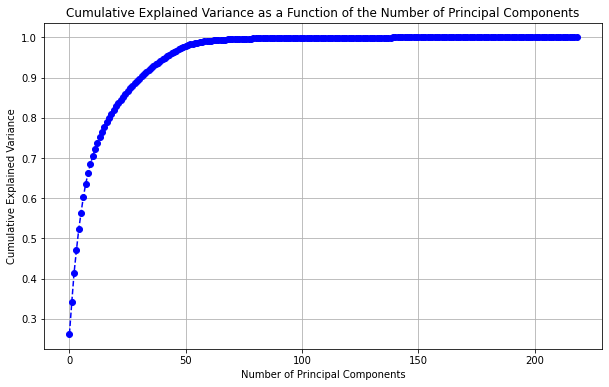

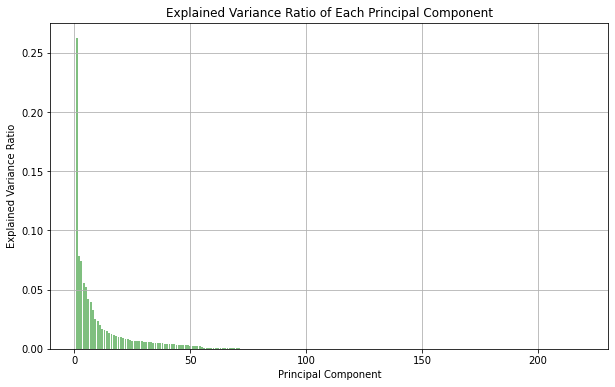

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(adp_data_filtered)

pca = PCA()
pca.fit(X_scaled)

explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance as a Function of the Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', color='g')
plt.title('Explained Variance Ratio of Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()


Total NaN values in dataset after dropping 'Unnamed: 231': 0


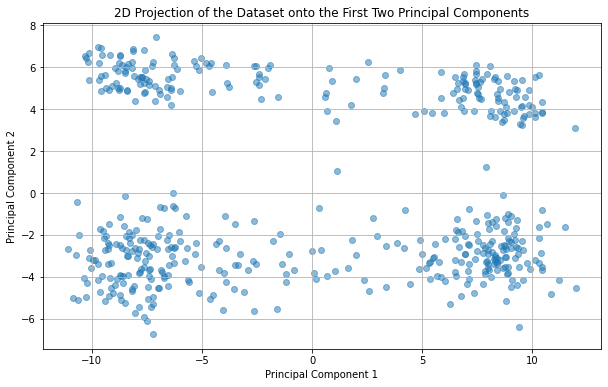

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('ADP_data.csv')

data.replace([np.inf, -np.inf], np.nan, inplace=True)

data.drop(columns=['Unnamed: 231'], inplace=True)

print(f"total NaN vals w/ 'Unnamed: 231': {data.isna().sum().sum()}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('2D Projection of the Dataset onto the First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()



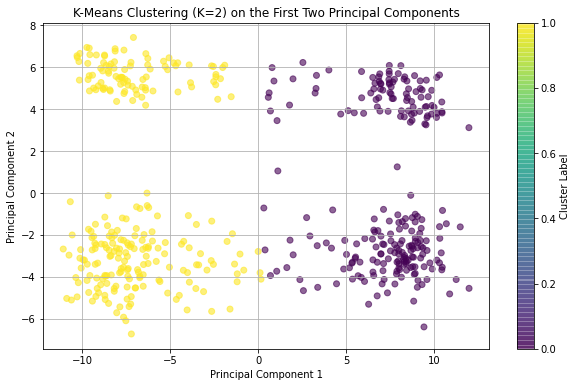

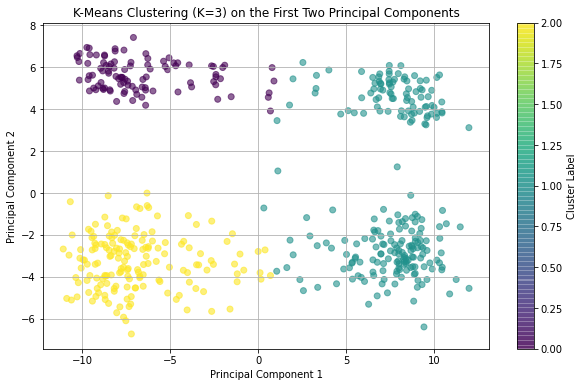

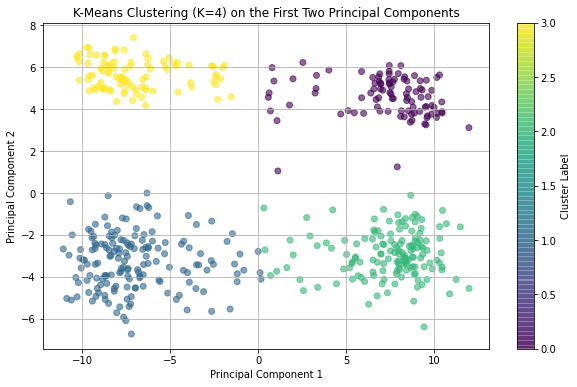

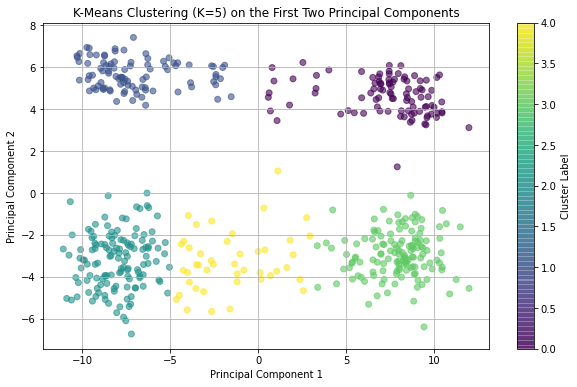

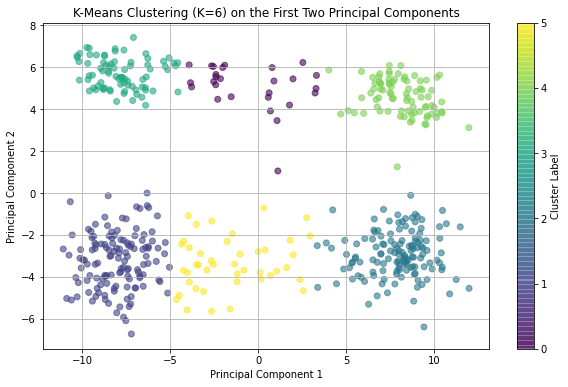

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

data = pd.read_csv('ADP_data.csv')

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.drop(columns=['Unnamed: 231'], inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    labels = kmeans.labels_

    plt.figure(figsize=(10, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.title(f'K-Means Clustering (K={k}) on the First Two Principal Components')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.colorbar(label='Cluster Label')
    plt.show()


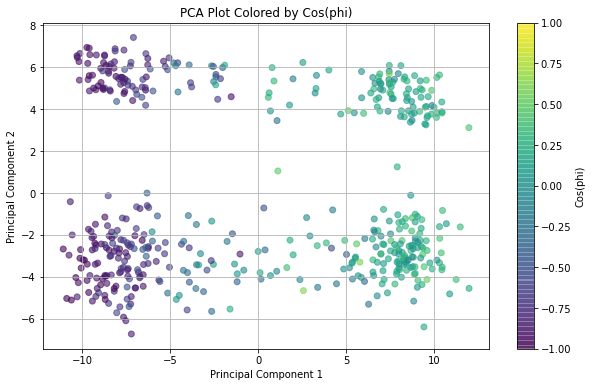

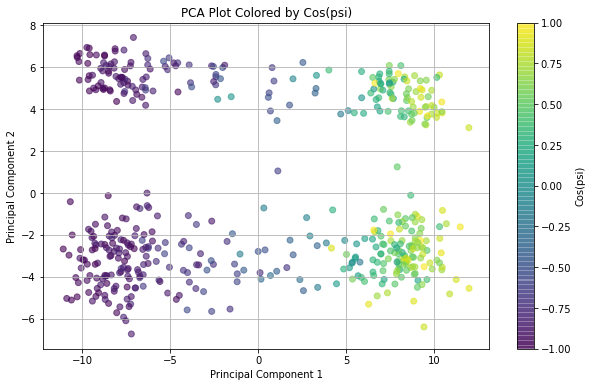

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('ADP_data.csv')
dihedrals = pd.read_csv('ADP_dihedrals.csv')

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.drop(columns=['Unnamed: 231'], inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

cm = plt.cm.get_cmap("viridis")

#cos(phi)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dihedrals['Cos[phi]'], cmap=cm, vmin=-1, vmax=1, alpha=0.6)
plt.title('PCA Plot Colored by Cos(phi)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cos(phi)')
plt.grid(True)
plt.show()

#cos(psi)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dihedrals['Cos[psi]'], cmap=cm, vmin=-1, vmax=1, alpha=0.6)
plt.title('PCA Plot Colored by Cos(psi)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cos(psi)')
plt.grid(True)
plt.show()
